In [64]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from progressbar import progressbar
%matplotlib inline

In [52]:
# Importing data and defining helper Functions
words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set(list(''.join(words)))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

# Train-Dev-Test Split

In [53]:
def build_dataset(words, block_size=3):
    X,Y = [],[]
    for w in words:
        # print(w)
        context = [0]*block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

In [54]:
# random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# Model

In [65]:
# g = torch.Generator().manual_seed(2147483647)

# PARAMETERS OF THE MODEL
n = 10 # dimensionality of the embedding
hyper_parameter = 200 # number of neurons in the hidden layer
batch_size = 128 # batch size of the training data, (note to self: keep it in powers of 2)
block_size = 5 # context length: how many chars are used to predict the next char


# TRAIN VAL TEST DATA OF THE MODEL
print("Training size: ")
Xtr, Ytr = build_dataset(words[:n1], block_size)
print("\nValidation size: ")
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
print("\nTest size: ")
Xte, Yte = build_dataset(words[n2:], block_size)


# DEFINIG THE MODEL
C = torch.randn((27,n), generator = g) # embedding each letter into a n dimensional vector
emb = C[Xtr]

print("\nEmbedding shape: ", emb.shape)


W1 = torch.randn((emb.shape[1]*emb.shape[2],hyper_parameter), generator=g) # n*block_size inputs, hyper_parameter neurons in the hidden layer
b1 = torch.randn(hyper_parameter, generator=g)
W2 = torch.randn((hyper_parameter, 27), generator=g) # hyper_parameter number of inputs, 27 possible predicted output char
b2 = torch.randn(27, generator=g)


parameters = [C, W1, b1, W2, b2]

print("num parameters: ", sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

Training size: 
torch.Size([182357, 5]) torch.Size([182357])

Validation size: 
torch.Size([22884, 5]) torch.Size([22884])

Test size: 
torch.Size([22905, 5]) torch.Size([22905])

Embedding shape:  torch.Size([182357, 5, 10])
num parameters:  15897


# Training the model

In [66]:
# # uncomment to help in deciding learning rate
# lre = torch.linspace(-3,0,1000)
# lrs = 10**lre
# lri = []

lossi = []
stepi = []

In [67]:
for i in progressbar(range(200000)):
    # Construct 32 minibatches
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # Forward pass
    emb = C[Xtr[ix]] # fetch 32 rows=> emb shape will be 32,3,2
    h = torch.tanh(emb.view(-1,emb.shape[1]*emb.shape[2])@W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print("Loss at itr", i, "is: ",loss.item())
    # backward pass
    for p in parameters:
        p.grad = None

    # update grads
    loss.backward()

    # update parameters

    # # uncomment to help in deciding lr
    # lr = lrs[i]
    # for p in parameters:
    #     p.data += -lr * p.grad
    # lri.append(lre[i])
    # lossi.append(loss.item())

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    lossi.append(loss.log10().item())
    stepi.append(i)

print("Final loss is: ", loss.item())
# plt.title("Exponent of Learning rate VS loss")
# plt.plot(lri,lossi)

100% (200000 of 200000) |################| Elapsed Time: 0:03:33 Time:  0:03:33


Final loss is:  2.105623245239258


# Plotting the steps and log losses

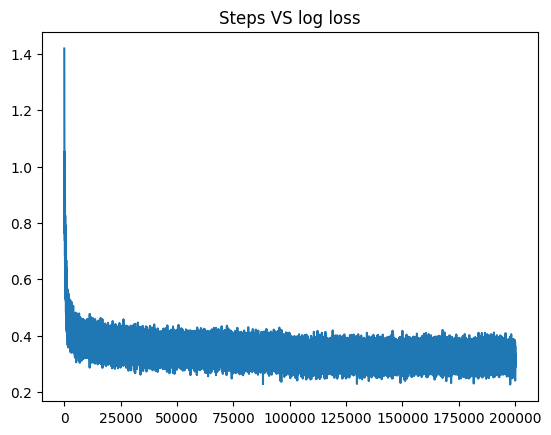

In [59]:
plt.title("Steps VS log loss")
plt.plot(stepi,lossi)

# Checking for Over/Under fitting using dev and train set

In [60]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,emb.shape[1]*emb.shape[2])@W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.1258223056793213

In [61]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,emb.shape[1]*emb.shape[2])@W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.1699323654174805

# Using the Test data to check the performance of the model

In [62]:
emb = C[Xte]
h = torch.tanh(emb.view(-1,emb.shape[1]*emb.shape[2])@W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss.item()

2.1619248390197754

# Sampling from the model

In [70]:
for _ in range(20):
    out = []
    context = [0]*block_size # init with all ...
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1  + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[ix] for ix in out))

dasyn.
lawar.
domanaely.
amisle.
deodrah.
mayet.
juhalea.
hanal.
maijem.
azav.
lihe.
jkaim.
isaeri.
meids.
trista.
avie.
meitley.
frethinnelynn.
evree.
broebyn.
